In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# AffectNet Training Data
with zipfile.ZipFile('/content/drive/MyDrive/T/Facial_Expressions_Training_Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/affectnet')

# FER2013
with zipfile.ZipFile('/content/drive/MyDrive/T/FER_2013.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/fer2013')

# MMA Facial Expression
with zipfile.ZipFile('/content/drive/MyDrive/T/MMA_FACIAL_EXPRESSION.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mma')

# Testing FER
with zipfile.ZipFile('/content/drive/MyDrive/T/testing_FER.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/testing-fer')

In [3]:
!ls /content/affectnet
!ls /content/fer2013
!ls /content/mma
!ls /content/testing-fer

anger  contempt  disgust  fear	happy  labels.csv  neutral  sad  surprise
test  train
MMAFEDB
testing_FER


In [4]:
!pip install datasets
!pip install transformers huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
!pip install matplotlib-venn

In [6]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [7]:
!pip uninstall datasets -y

Found existing installation: datasets 3.2.0
Uninstalling datasets-3.2.0:
  Successfully uninstalled datasets-3.2.0


In [8]:
!pip install datasets evaluate

  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
Using cached datasets-3.2.0-py3-none-any.whl (480 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,f1_score
import cv2
import os
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import load_dataset, concatenate_datasets
from evaluate import load # Import load from evaluate
from huggingface_hub import notebook_login
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)
import itertools  # Import 'itertools' for iterators and looping

In [10]:
model_checkpoint = "motheecreator/vit-Facial-Expression-Recognition" # pre-trained model from which to fine-tune

In [11]:
from datasets import load_dataset, concatenate_datasets
from evaluate import load # Import load from evaluate

metric = load("accuracy") # Use load instead of load_metric

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
from datasets import load_dataset

af_dataset = load_dataset("imagefolder", data_dir="/content/affectnet")

Resolving data files:   0%|          | 0/29043 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
af_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 29042
    })
})

In [14]:
from datasets import DatasetDict, ClassLabel

# Assuming `dataset` is already defined
# Get the label names
label_names = af_dataset['train'].features['label'].names

# Get the index of the 'contempt' label
contempt_index = label_names.index('contempt')

# Filter out the rows with 'contempt' label
filtered_dataset = af_dataset['train'].filter(lambda example: example['label'] != contempt_index)

# Remove 'contempt' from the label names
new_label_names = [name for name in label_names if name != 'contempt']

# Create a new ClassLabel feature without 'contempt'
new_label_feature = ClassLabel(names=new_label_names)

# Function to remap labels to the new indices
def remap_label(label):
    return new_label_feature.str2int(label_names[label])

# Update the dataset's label feature
filtered_dataset = filtered_dataset.map(lambda example: {'label': remap_label(example['label'])})

# Update the dataset features
filtered_dataset = filtered_dataset.cast_column('label', new_label_feature)

# Update the DatasetDict
af_dataset = DatasetDict({'train': filtered_dataset})

# Verify the change
print(af_dataset)

Filter:   0%|          | 0/29042 [00:00<?, ? examples/s]

Map:   0%|          | 0/26171 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/26171 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 26171
    })
})


In [15]:
from datasets import DatasetDict, ClassLabel

# Assuming `dataset` is already defined

# Get the label names
label_names = af_dataset['train'].features['label'].names

# Check if 'anger' exists in label_names before changing it
if 'anger' in label_names:
    # Change 'anger' to 'angry' in label names
    new_label_names = [name if name != 'anger' else 'angry' for name in label_names]

    # Update the label names in the dataset
    af_dataset['train'] = af_dataset['train'].rename_column('label', 'old_label')
    af_dataset['train'] = af_dataset['train'].rename_column('old_label', 'label')

    # Update the label 'anger' to 'angry' in the dataset
    af_dataset['train'] = af_dataset['train'].map(lambda example: {'label': 'angry' if example['label'] == 'anger' else example['label']})

    # Update the ClassLabel feature
    new_label_feature = ClassLabel(names=new_label_names)

    # Update the dataset's label feature
    af_dataset['train'] = af_dataset['train'].cast_column('label', new_label_feature)

# Verify the change
print(af_dataset)


Map:   0%|          | 0/26171 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/26171 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 26171
    })
})


In [16]:
fer_dataset = load_dataset("imagefolder", data_dir="/content/fer2013")

Resolving data files:   0%|          | 0/28709 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7178 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [17]:
fer_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 28709
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 7178
    })
})

In [18]:
mmi_dataset = load_dataset("imagefolder", data_dir="/content/mma")

Resolving data files:   0%|          | 0/92968 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17356 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17356 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [19]:
mmi_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 92968
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 17356
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 17356
    })
})

In [20]:
combined_dataset = concatenate_datasets([af_dataset['train'],fer_dataset['train'],mmi_dataset['train']])

In [21]:
dataset = DatasetDict()

In [22]:
dataset['train'] = combined_dataset

In [23]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 147848
    })
})

In [24]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 0}

In [25]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None)}

In [26]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [27]:
label2id

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [28]:
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [29]:
# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = image_processor.image_mean, image_processor.image_std

# Get the size (height) of the ViT model's input images
size = image_processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
train_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                          # Normalize images using mean and std
    ]
)
# Define a set of transformations for validation data
val_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

Size:  224


In [30]:
# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [train_tf(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [val_tf(image.convert("RGB")) for image in examples['image']]
    return examples

In [31]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.2)
train_data = splits['train']
val_data = splits['test']

In [32]:
train_data

Dataset({
    features: ['image', 'label'],
    num_rows: 118278
})

In [33]:
val_data

Dataset({
    features: ['image', 'label'],
    num_rows: 29570
})

In [34]:
train_data.set_transform(train_transforms)
val_data.set_transform(val_transforms)

In [35]:
train_data[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=96x96>,
 'label': 4,
 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -

In [36]:
val_data[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=48x48>,
 'label': 3,
 'pixel_values': tensor([[[-0.3176, -0.3176, -0.3255,  ...,  0.4431,  0.4431,  0.4431],
          [-0.3176, -0.3176, -0.3255,  ...,  0.4431,  0.4431,  0.4431],
          [-0.3176, -0.3176, -0.3255,  ...,  0.4431,  0.4431,  0.4431],
          ...,
          [-0.7412, -0.7412, -0.7412,  ..., -0.6235, -0.6235, -0.6235],
          [-0.7412, -0.7412, -0.7412,  ..., -0.6235, -0.6235, -0.6235],
          [-0.7412, -0.7412, -0.7412,  ..., -0.6235, -0.6235, -0.6235]],
 
         [[-0.4980, -0.4980, -0.5059,  ...,  0.5216,  0.5216,  0.5216],
          [-0.4980, -0.4980, -0.5059,  ...,  0.5216,  0.5216,  0.5216],
          [-0.4980, -0.4980, -0.5059,  ...,  0.5216,  0.5216,  0.5216],
          ...,
          [-0.7255, -0.7255, -0.7255,  ..., -0.6235, -0.6235, -0.6235],
          [-0.7255, -0.7255, -0.7255,  ..., -0.6235, -0.6235, -0.6235],
          [-0.7255, -0.7255, -0.7255,  ..., -0.6235, -0.6235, -0.6235]],


In [37]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

In [38]:
notebook_login()

In [39]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",  # Align with evaluation_strategy
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    auto_find_batch_size=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=32,
    weight_decay=0.1,
    num_train_epochs=3,
    warmup_steps=1000,
    logging_steps=50,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="none"
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from evaluate import load

# Load the accuracy metric (if not already loaded)
metric = load("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy, precision, recall, and F1-score on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)

    # Calculate accuracy using 'metric.compute'
    accuracy = metric.compute(predictions=predictions, references=eval_pred.label_ids)['accuracy']

    # Calculate precision, recall, and F1-score using sklearn.metrics
    precision = precision_score(eval_pred.label_ids, predictions, average='weighted')
    recall = recall_score(eval_pred.label_ids, predictions, average='weighted')
    f1 = f1_score(eval_pred.label_ids, predictions, average='weighted')

    # Return a dictionary containing all computed metrics
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

In [ ]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [41]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [42]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

<ipython-input-42-a35d21ec3329>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [43]:
import time

# Start tracking training time
start_time = time.time()

# Train the model and store results
train_results = trainer.train()

# Calculate total train time
total_train_time = time.time() - start_time

# Now you can use 'total_train_time' to report or log the training duration
print(f"Total training time: {total_train_time:.2f} seconds")

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,4.561800,0.371007,0.876158,0.874627,0.875166,0.876158
200,4.609100,0.367663,0.876124,0.874696,0.876240,0.876124
300,4.542300,0.369518,0.874772,0.873048,0.874523,0.874772
400,4.630700,0.374467,0.871052,0.869201,0.872954,0.871052
500,4.395300,0.374472,0.872709,0.871108,0.872448,0.872709
600,4.341000,0.380298,0.868820,0.867416,0.868773,0.868820
700,4.547100,0.384110,0.871288,0.869892,0.871023,0.871288
800,4.522000,0.383645,0.867873,0.866240,0.867763,0.867873
900,4.559600,0.388478,0.867196,0.864878,0.867834,0.867196
1000,4.149100,0.384886,0.869056,0.867707,0.868888,0.869056


Could not locate the best model at vit-Facial-Expression-Recognition/checkpoint-100/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Total training time: 16669.22 seconds


In [44]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =     2.9954
  eval_accuracy           =     0.8753
  eval_f1                 =     0.8737
  eval_loss               =     0.3658
  eval_precision          =     0.8749
  eval_recall             =     0.8753
  eval_runtime            = 0:05:49.26
  eval_samples_per_second =     84.662
  eval_steps_per_second   =      2.648


In [46]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/Thao2202/vit-Facial-Expression-Recognition/commit/878e00bcff151f36c0b092ecef0c69866e3db578', commit_message='End of training', commit_description='', oid='878e00bcff151f36c0b092ecef0c69866e3db578', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Thao2202/vit-Facial-Expression-Recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='Thao2202/vit-Facial-Expression-Recognition'), pr_revision=None, pr_num=None)

In [47]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(val_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.36578133702278137, 'test_accuracy': 0.8752789989854582, 'test_f1': 0.8737068810871955, 'test_precision': 0.8748779898220497, 'test_recall': 0.8752789989854582, 'test_runtime': 349.3683, 'test_samples_per_second': 84.638, 'test_steps_per_second': 2.648}


In [48]:
pipe=pipeline(model = 'Thao2202/vit-Facial-Expression-Recognition')

config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

Device set to use cuda:0


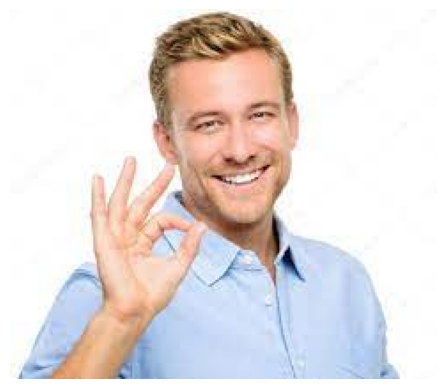

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image file
image_path = '/content/testing-fer/testing_FER/happy1.jpg'  # Replace with the actual path to your image file
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [50]:
pipe("/content/testing-fer/testing_FER/happy1.jpg")

[{'label': 'happy', 'score': 0.9896129965782166},
 {'label': 'surprise', 'score': 0.7576410174369812},
 {'label': 'angry', 'score': 0.5671684145927429},
 {'label': 'fear', 'score': 0.4445437490940094},
 {'label': 'neutral', 'score': 0.1949891895055771}]

Accuracy: 0.8753
F1 Score: 0.8350


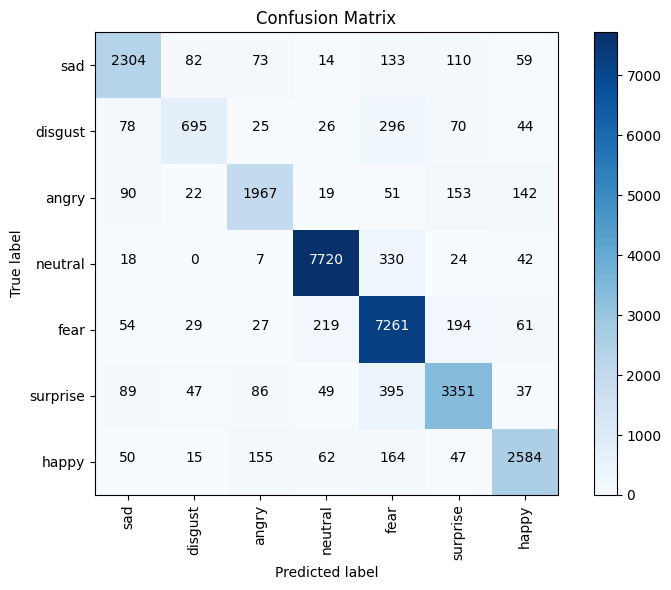


Classification report:

              precision    recall  f1-score   support

         sad     0.8587    0.8303    0.8443      2775
     disgust     0.7809    0.5632    0.6544      1234
       angry     0.8406    0.8048    0.8223      2444
     neutral     0.9520    0.9483    0.9502      8141
        fear     0.8414    0.9256    0.8815      7845
    surprise     0.8486    0.8266    0.8374      4054
       happy     0.8703    0.8398    0.8548      3077

    accuracy                         0.8753     29570
   macro avg     0.8561    0.8198    0.8350     29570
weighted avg     0.8749    0.8753    0.8737     29570



In [51]:
labels_list = ['sad', 'disgust', 'angry', 'neutral', 'fear', 'surprise', 'happy'] # list(set(labels))
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

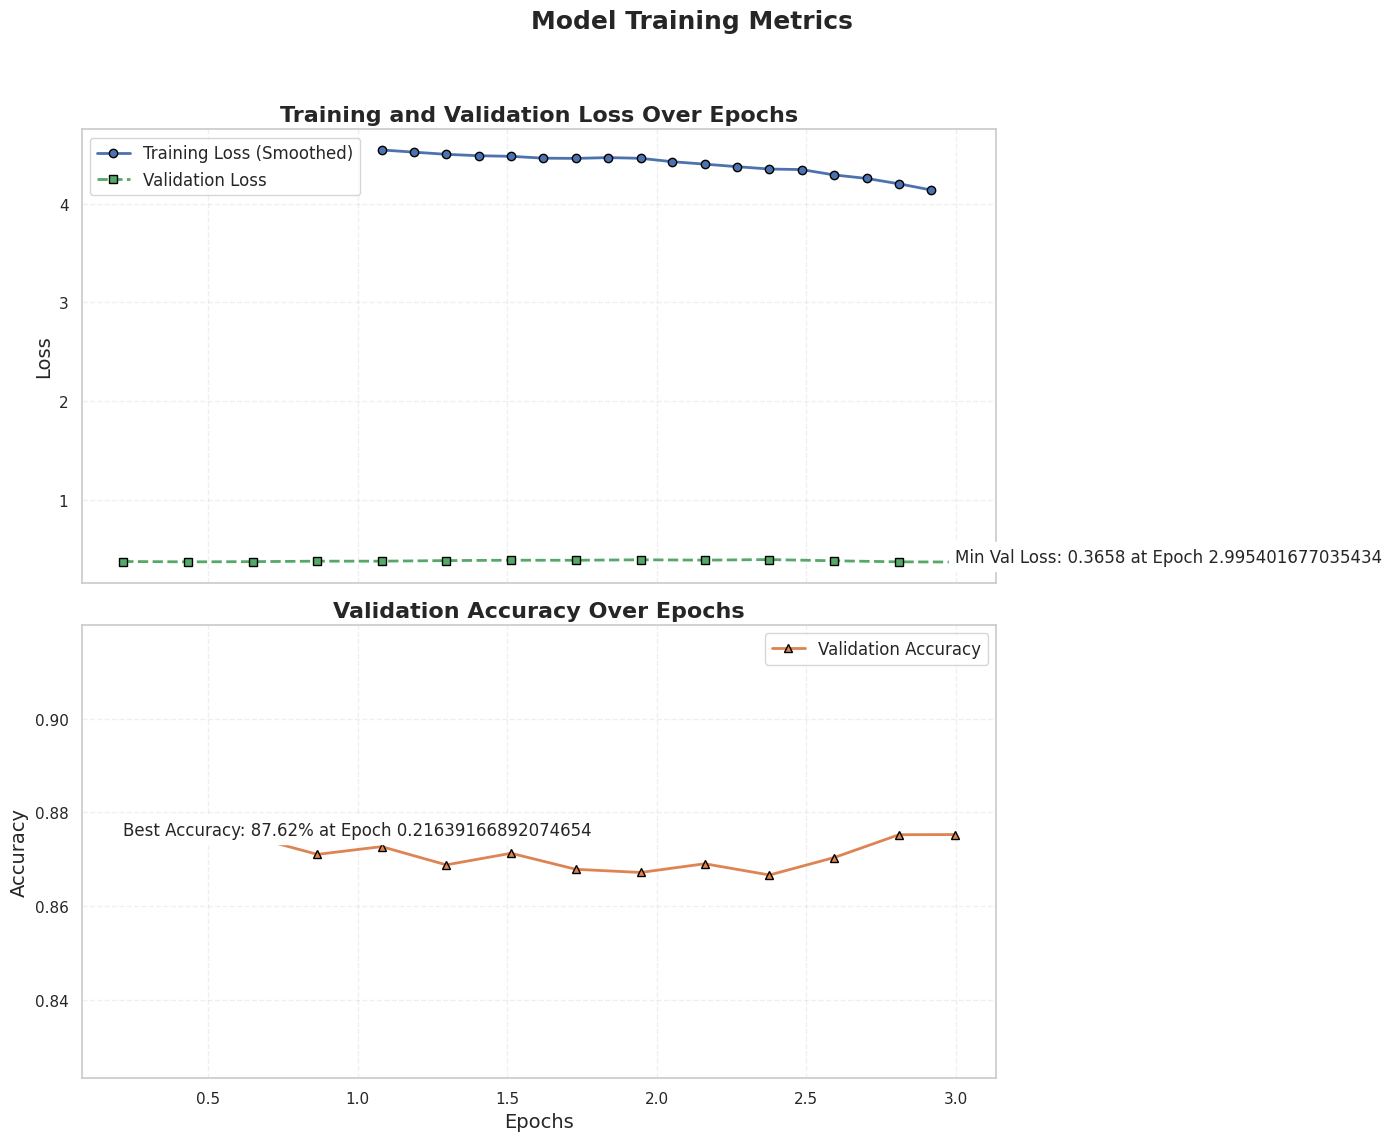

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Configure Matplotlib to display Chinese characters and handle negative signs
plt.rcParams['font.sans-serif'] = ['SimHei']  # Use SimHei font for Chinese characters
plt.rcParams['axes.unicode_minus'] = False    # Ensure minus signs are displayed correctly

# Initialize lists to store metrics
train_epochs = []
train_loss = []
eval_epochs = []
eval_loss = []
eval_accuracy = []

# Iterate through the log_history to extract metrics
for log in trainer.state.log_history:
    if "epoch" in log:
        current_epoch = log["epoch"]

        if "loss" in log:
            # Assuming training loss is logged multiple times per epoch (e.g., per batch)
            train_epochs.append(current_epoch)
            train_loss.append(log["loss"])

        if "eval_loss" in log:
            # Evaluation metrics are typically logged once per epoch
            eval_epochs.append(current_epoch)
            eval_loss.append(log["eval_loss"])

        if "eval_accuracy" in log:
            eval_accuracy.append(log["eval_accuracy"])

# Ensure that evaluation metrics have corresponding epochs
assert len(eval_epochs) == len(eval_loss) == len(eval_accuracy), "Mismatch in evaluation metrics lengths."

# Optional: Smooth training loss using a rolling average (e.g., window size of 10)
window_size = 10
if len(train_loss) >= window_size:
    train_loss_smooth = np.convolve(train_loss, np.ones(window_size)/window_size, mode='valid')
    train_epochs_smooth = train_epochs[window_size-1:]
else:
    train_loss_smooth = train_loss
    train_epochs_smooth = train_epochs

# Identify the epoch with the best validation accuracy
best_epoch = eval_epochs[np.argmax(eval_accuracy)]
best_accuracy = max(eval_accuracy)

# Create a color palette
palette = sns.color_palette("deep")

# Create subplots with shared x-axis
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# --- Subplot 1: Loss Curves ---
axes[0].plot(train_epochs_smooth, train_loss_smooth, label="Training Loss (Smoothed)",
             color=palette[0], linewidth=2, marker='o', markersize=6, markeredgecolor='black')
axes[0].plot(eval_epochs, eval_loss, label="Validation Loss",
             color=palette[2], linewidth=2, linestyle='--', marker='s', markersize=6, markeredgecolor='black')
axes[0].set_title("Training and Validation Loss Over Epochs", fontsize=16, fontweight="bold")
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.3)

# Optionally, add annotations to each training loss point
# for epoch, loss in zip(train_epochs_smooth, train_loss_smooth):
#     axes[0].text(epoch, loss, f"{loss:.4f}", fontsize=8, ha='center', va='bottom')

# Optionally, add annotations to each validation loss point
# for epoch, loss in zip(eval_epochs, eval_loss):
#     axes[0].text(epoch, loss, f"{loss:.4f}", fontsize=8, ha='center', va='bottom')

# Annotate the minimum validation loss
min_val_loss = min(eval_loss)
min_loss_epoch = eval_epochs[eval_loss.index(min_val_loss)]
axes[0].annotate(f"Min Val Loss: {min_val_loss:.4f} at Epoch {min_loss_epoch}",
                xy=(min_loss_epoch, min_val_loss),
                xytext=(min_loss_epoch, min_val_loss + (max(eval_loss)-min(eval_loss))*0.1),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=12, backgroundcolor='white')

# --- Subplot 2: Accuracy Curve ---
axes[1].plot(eval_epochs, eval_accuracy, label="Validation Accuracy",
             color=palette[1], linewidth=2, marker='^', markersize=6, markeredgecolor='black')
axes[1].set_title("Validation Accuracy Over Epochs", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_ylim([min(eval_accuracy) * 0.95, max(eval_accuracy) * 1.05])  # Adjust y-axis range
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.3)

# Optionally, add annotations to each validation accuracy point
# for epoch, acc in zip(eval_epochs, eval_accuracy):
#     axes[1].text(epoch, acc, f"{acc:.2%}", fontsize=8, ha='center', va='bottom')

# Annotate the best validation accuracy
axes[1].annotate(f"Best Accuracy: {best_accuracy:.2%} at Epoch {best_epoch}",
                xy=(best_epoch, best_accuracy),
                xytext=(best_epoch, best_accuracy - (max(eval_accuracy)-min(eval_accuracy))*0.1),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=12, backgroundcolor='white')

# Add an overall title
fig.suptitle("Model Training Metrics", fontsize=18, fontweight="bold")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Optional: Save the plot as a high-resolution image
# plt.savefig("model_training_metrics.png", dpi=300)

# Display the plot
plt.show()